In [1]:
from signal_miner import *

import pandas as pd
import numpy as np
import random
from numerapi import NumerAPI
import lightgbm as lgb
import pickle
import os
from multiprocessing import Pool
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [2]:
# Download and initialize data
napi = NumerAPI()
napi.download_dataset("v5.0/train.parquet", "v5.0/train.parquet")
napi.download_dataset("v5.0/validation.parquet", "v5.0/validation.parquet")

data = pd.concat([ pd.read_parquet("v5.0/train.parquet"), pd.read_parquet("v5.0/validation.parquet") ])

targets = [t for t in data.columns if 'target' in t]
feature_cols = [c for c in data.columns if 'feature' in c]

data['era'] = data['era'].astype('int')
data[targets] = (data[targets] * 4).astype('Int8')

eras = np.array(sorted(data['era'].unique()))

2025-02-13 17:14:30,203 INFO numerapi.utils: target file already exists
2025-02-13 17:14:30,204 INFO numerapi.utils: download complete
2025-02-13 17:14:31,122 INFO numerapi.utils: target file already exists
2025-02-13 17:14:31,123 INFO numerapi.utils: starting download
v5.0/validation.parquet: 6.63GB [04:57, 22.3MB/s]                                                                       


In [3]:
save_name = "signal_miner_1" #unique job identifier

In [4]:
n_jobs = 10
n_processes = 2
ns = 2 #number of splits
niter = 1000  # number of configurations (size of job)
max_trees = 30_000

In [ ]:
# Define the benchmark configuration
# benchmark_cfg = {
#     "colsample_bytree": 0.1,
#     "max_bin": 5,
#     "max_depth": 5,
#     "num_leaves": 2**4-1,
#     "min_child_samples": 20,
#     "n_estimators": 2000,
#     "reg_lambda": 0.0,
#     "learning_rate": 0.01,
#     "target": 'target',  # Use the first target for simplicity
#     "n_jobs": n_jobs,
#     "bagging_freq": 0,
#     "bagging_fraction": 1,
# }

benchmark_cfg = {
    "colsample_bytree": 0.1,
    "max_bin": 5,
    "max_depth": 10,
    "num_leaves": 2**10,
    "min_child_samples": 10000,
    "n_estimators": max_trees,
    "reg_lambda": 0.0,
    "learning_rate": 0.001,
    "target": 'target',  # Use the first target for simplicity
    "n_jobs": n_jobs,
    # "bagging_freq": 0,
    # "bagging_fraction": 1,
}

# Parameter dictionary
param_dict = {
    'colsample_bytree': list(np.linspace(0.001, 1, 100)), 
    'reg_lambda': list(np.linspace(0, 100_000, 10000)),
    'learning_rate': list( np.linspace(.00001, 0.3, 1000, dtype='float') ),
    'max_bin' : list(np.linspace(2, 5, 4, dtype='int')),
    'max_depth': list(np.linspace(5, 16, 12, dtype='int')),# [5, 10, 15, 20, 25, 50, 100],
    'num_leaves': list(np.linspace(4, 2048, 2044, dtype='int')),#, 4112],#, 8192, 32768],
    'min_child_samples': list( np.linspace(1,15000,15000,dtype='int') ),
    'n_estimators': list( np.linspace(10,max_trees,max_trees-10,dtype='int') ),#,75,100,150,200],#, 500, 700, 900, 1200], 
    'target':targets,
    'n_jobs': [n_jobs],
    # "bagging_freq": list( np.linspace(1, max_trees, max_trees, dtype='int') ),
    # "bagging_fraction": list( np.linspace(0, 1, 1000) ),
}

# Cross-validation splits
all_splits = list(TimeSeriesSplit(n_splits=ns, max_train_size=100_000_000, gap=12).split(eras))

# Ensure the results directory exists
os.makedirs("results", exist_ok=True)

# Define file paths
pickle_file = f'results/{save_name}_config.pkl'
mmapped_array_file = os.path.join("results", f"{save_name}_test_mmapped_array.dat")
done_splits_file = os.path.join("results", f"{save_name}_test_done_splits.dat")

# Expected dimensions
expected_mmap_shape = (len(data), niter + 1) # plus 1 for benchmark
expected_done_splits_shape = (len(all_splits) * (niter + 1),)

# Function to check file existence and dimensions
def check_mmap_file(filepath, dtype, expected_shape):
    if os.path.exists(filepath):
        try:
            mmap = np.memmap(filepath, dtype=dtype, mode='r')
            return mmap.shape == expected_shape
        except Exception as e:
            print(f"Error checking {filepath}: {e}")
            return False
    return False

# Check if all files exist and have correct dimensions
config_exists = os.path.exists(pickle_file)
mmap_valid = check_mmap_file(mmapped_array_file, 'float16', expected_mmap_shape)
done_splits_valid = check_mmap_file(done_splits_file, 'float16', expected_done_splits_shape)

if config_exists and mmap_valid and done_splits_valid:
    # Load existing configuration
    with open(pickle_file, 'rb') as f:
        configurations = pickle.load(f)

    # Load memory-mapped arrays
    mmapped_array = np.memmap(mmapped_array_file, dtype='float16', mode='r+',
                              shape=expected_mmap_shape)
    done_splits = np.memmap(done_splits_file, dtype='float16', mode='r+',
                            shape=expected_done_splits_shape)

    print(f"Loaded existing results for {save_name}.")
else:
    # Save new configuration
    configurations = get_rdn_cfgs(param_dict, niter)

    # Add benchmark configuration as the first entry
    # configurations.insert(0, benchmark_cfg)
    # BENCHMARK_ID = 0
    
    with open(pickle_file, 'wb') as f:
        pickle.dump(configurations, f)

    # Initialize new memory-mapped arrays
    mmapped_array = np.memmap(mmapped_array_file, dtype='float16', mode='w+',
                              shape=expected_mmap_shape)
    done_splits = np.memmap(done_splits_file, dtype='float16', mode='w+',
                            shape=expected_done_splits_shape)

    print(f"Initialized new results for {save_name}.")

data['mmap_idx'] = range(len(data))

# Define the processing function
def process_split(task):
    train_didxs, test_didxs, k, cfg, split_id, split_num = task
    print(cfg)
    try:
        label = cfg['target']
        train_rows = (data['era'].isin(eras[train_didxs])) & (~data[label].isna())
        test_rows = (data['era'].isin(eras[test_didxs])) & (~data[label].isna())

        model = get_model(cfg)

        model.fit(
            data.loc[train_rows, feature_cols].values,
            data.loc[train_rows, label].values
        )

        result_vector = model.predict(data.loc[test_rows, feature_cols].values)
        mmapped_array[data.loc[test_rows, 'mmap_idx'].values, k] = result_vector
        done_splits[split_id] = 1
        done_splits.flush()
    except Exception as e:
        print(f"Error in process_split: {e}")

# Start mining
pool = Pool(processes=2)

def start_mining():
    split_data_list = []
    split_id = 0
    for k, cfg in enumerate(configurations):
        for i, (train_didxs, test_didxs) in enumerate(all_splits):
            task = (train_didxs, test_didxs, k, cfg, split_id, i)
            split_data_list.append(task)
            split_id += 1

    pool.imap(process_split, split_data_list, chunksize=1)

# Check progress
def check_progress():
    completed = np.sum(done_splits)
    total = len(done_splits)
    print(f"Progress: {completed}/{total} ({(completed / total) * 100:.2f}%)")

# End mining
def end_mining():
    global pool
    if pool is not None:
        pool.terminate()
        pool.close()
        pool.join()
        pool = None

# Example usage
start_mining()  # Start mining asynchronously
# check_progress()  # Check progress
# end_mining()  # Stop the pool when done

In [9]:
pd.DataFrame( configurations )#[['num_leaves']].plot()

,colsample_bytree,reg_lambda,learning_rate,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,target,n_jobs
0,0.344091,1060.106011,0.188292,5,14,1054,11968,23477,target_caroline_60,10
1,0.727545,50715.071507,0.022231,2,14,1162,4712,14834,target_tyler_20,10
2,0.414727,18001.800180,0.276878,3,15,1819,12804,924,target_xerxes_60,10
3,0.979818,36733.673367,0.136342,2,16,1881,6807,24874,target_caroline_60,10
4,0.697273,1970.197020,0.003914,3,13,1259,11824,1323,target_alpha_60,10
...,...,...,...,...,...,...,...,...,...,...
995,0.394545,77157.715772,0.033943,5,13,764,14735,4177,target_caroline_60,10
996,0.293636,9900.990099,0.180184,5,11,343,4033,23158,target_tyler_60,10
997,0.091818,930.093009,0.189193,5,15,702,2629,7158,target_waldo_20,10
998,0.061545,85688.568857,0.279580,3,15,2002,14935,2755,target_agnes_20,10


In [129]:
# random.shuffle( configurations )

In [35]:
# pool = Pool(processes=2)
# start_mining()

{'colsample_bytree': 0.8486363636363636, 'reg_lambda': 33303.33033303331, 'learning_rate': 0.8378394594594595, 'max_bin': 2, 'max_depth': 4, 'num_leaves': 8, 'min_child_samples': 13583, 'n_estimators': 2629, 'target': 'target_alpha_20', 'n_jobs': 10}{'colsample_bytree': 0.8486363636363636, 'reg_lambda': 33303.33033303331, 'learning_rate': 0.8378394594594595, 'max_bin': 2, 'max_depth': 4, 'num_leaves': 8, 'min_child_samples': 13583, 'n_estimators': 2629, 'target': 'target_alpha_20', 'n_jobs': 10}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.351452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4752
[LightGBM] [Info] Number of data points in the train set: 1713297, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 18

In [33]:
# end_mining()


In [132]:
'''Check Progress Periodically'''
check_progress()

Progress: 46.0/2002 (2.30%)


In [133]:
# from signal_miner import evaluate_completed_configs
res_df = evaluate_completed_configs(data, configurations, mmapped_array, done_splits, all_splits, ns)

BENCHMARK_ID = -1
bm_scores = pd.read_csv('benchmark_results')
bm_scores.index = [BENCHMARK_ID]
res_df = pd.concat([res_df, bm_scores])

# Add a column to label benchmark configurations
res_df['is_benchmark'] = res_df.index == BENCHMARK_ID

In [134]:
print("Benchmark Results:")
# res_df[res_df['is_benchmark']].to_csv('benchmark_results')
res_df[res_df['is_benchmark']]

Benchmark Results:


,colsample_bytree,reg_lambda,learning_rate,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,target,n_jobs,...,validation_shp,validation_max_dd,test_corr,test_shp,test_max_dd,whole_corr,whole_shp,whole_max_dd,Unnamed: 0,is_benchmark
-1,0.1,0.0,0.001,5,10,1024,10000,30000,target,10,...,2.44343,0.01395,0.032886,1.695807,0.033968,0.036998,1.989195,0.033968,0.0,True


In [135]:
'''

Show All Models with Corr and Sharpe higher than benchmark on Entire Data Set

'''
print("Better Than Benchmark Results:")
compare_to_benchmark(res_df)

Better Than Benchmark Results:


,colsample_bytree,reg_lambda,learning_rate,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,target,n_jobs,...,validation_shp,validation_max_dd,test_corr,test_shp,test_max_dd,whole_corr,whole_shp,whole_max_dd,Unnamed: 0,is_benchmark
2,0.414727,18001.800180,0.276878,3,15,1819,12804,924,target_xerxes_60,10,...,1.222228,0.057119,0.017456,1.208506,0.023342,0.018509,1.211460,0.057119,NaN,False
9,0.535818,83488.348835,0.259161,4,10,329,69,3562,target_claudia_20,10,...,1.278614,0.040854,0.017333,1.127249,0.045310,0.018331,1.199976,0.045310,NaN,False
4,0.697273,1970.197020,0.003914,3,13,1259,11824,1323,target_alpha_60,10,...,1.281187,0.057419,0.022592,1.279523,0.084894,0.022142,1.279654,0.084894,NaN,False
7,0.808273,17541.754175,0.236038,5,10,264,10497,2190,target_delta_20,10,...,1.304182,0.057118,0.017193,1.092669,0.079057,0.019283,1.190750,0.079057,NaN,False
6,0.071636,99939.993999,0.134540,5,15,955,5151,26803,target_caroline_60,10,...,1.312096,0.040615,0.018740,1.343685,0.037341,0.019231,1.325428,0.040615,NaN,False
15,0.868818,2580.258026,0.157963,4,16,115,9730,2221,target_echo_20,10,...,1.314373,0.029271,0.016506,1.033520,0.121477,0.018366,1.163532,0.121477,NaN,False
21,0.737636,36133.613361,0.133939,3,13,30,12347,13069,target_waldo_20,10,...,1.339352,0.026923,0.018540,1.136145,0.051265,0.019693,1.232177,0.051265,NaN,False
11,0.656909,82548.254825,0.099406,5,11,1648,13678,12823,target_echo_60,10,...,1.409505,0.039057,0.020828,1.253607,0.054959,0.020738,1.325164,0.054959,NaN,False
1,0.727545,50715.071507,0.022231,2,14,1162,4712,14834,target_tyler_20,10,...,1.505023,0.057449,0.018444,1.154845,0.073933,0.020716,1.312603,0.073933,NaN,False
17,0.172545,34913.491349,0.103610,2,12,1600,1551,2262,target_tyler_20,10,...,1.511152,0.051654,0.018985,1.224264,0.057738,0.021385,1.353483,0.057738,NaN,False


In [136]:
res_df.sort_values('whole_corr')

,colsample_bytree,reg_lambda,learning_rate,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,target,n_jobs,...,validation_shp,validation_max_dd,test_corr,test_shp,test_max_dd,whole_corr,whole_shp,whole_max_dd,Unnamed: 0,is_benchmark
20,0.445000,21412.141214,0.021331,2,11,203,9595,1618,target_jeremy_60,10,...,0.072003,0.433770,0.002799,0.125630,0.479851,0.002042,0.100570,0.479851,NaN,False
8,0.112000,35663.566357,0.239642,2,12,571,7670,16729,target_claudia_20,10,...,0.705413,0.204210,0.009620,0.664203,0.119755,0.010065,0.684799,0.204210,NaN,False
16,0.404636,70747.074707,0.251053,2,14,1796,4975,26644,target_alpha_60,10,...,0.730938,0.170102,0.009887,0.704089,0.140409,0.010131,0.717663,0.170102,NaN,False
13,0.364273,13221.322132,0.172076,2,13,1731,8113,9676,target_jeremy_20,10,...,0.853542,0.147879,0.010223,0.623649,0.187896,0.011520,0.730786,0.187896,NaN,False
3,0.979818,36733.673367,0.136342,2,16,1881,6807,24874,target_caroline_60,10,...,0.821550,0.133951,0.011502,0.805863,0.069093,0.012126,0.812766,0.133951,NaN,False
12,0.586273,560.056006,0.199403,5,11,449,9469,22205,target_bravo_20,10,...,0.834418,0.172231,0.012229,0.803959,0.094859,0.012642,0.819090,0.172231,NaN,False
22,0.455091,13891.389139,0.154659,2,10,97,7203,9967,target_ralph_60,10,...,0.827983,0.184888,0.013199,0.897285,0.065246,0.012943,0.861105,0.184888,NaN,False
0,0.344091,1060.106011,0.188292,5,14,1054,11968,23477,target_caroline_60,10,...,0.972644,0.044700,0.014524,1.062027,0.062300,0.014624,1.013101,0.062300,NaN,False
10,0.606455,48154.815482,0.189493,5,15,225,2683,14030,target_tyler_20,10,...,1.029209,0.120356,0.014229,0.883025,0.103631,0.015576,0.953838,0.120356,NaN,False
9,0.535818,83488.348835,0.259161,4,10,329,69,3562,target_claudia_20,10,...,1.278614,0.040854,0.017333,1.127249,0.045310,0.018331,1.199976,0.045310,NaN,False


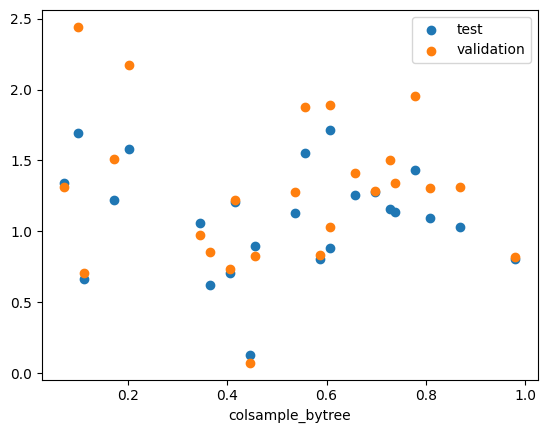

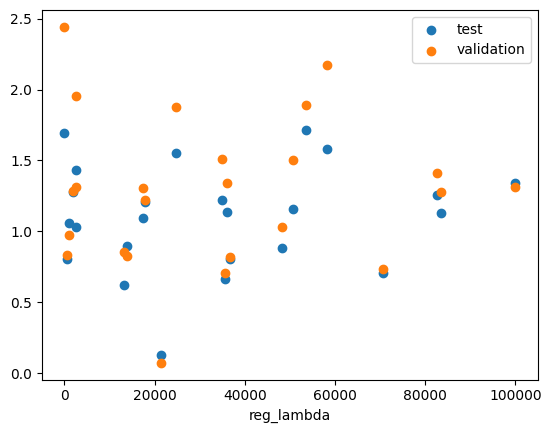

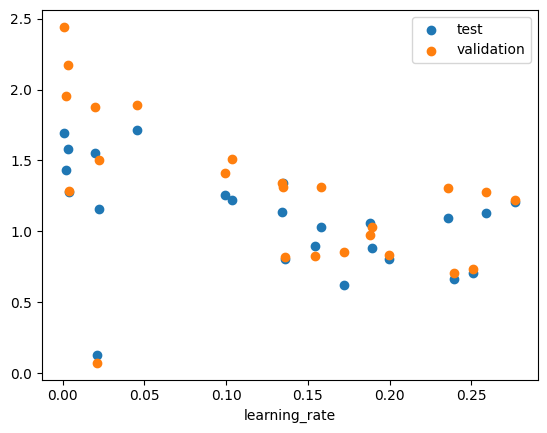

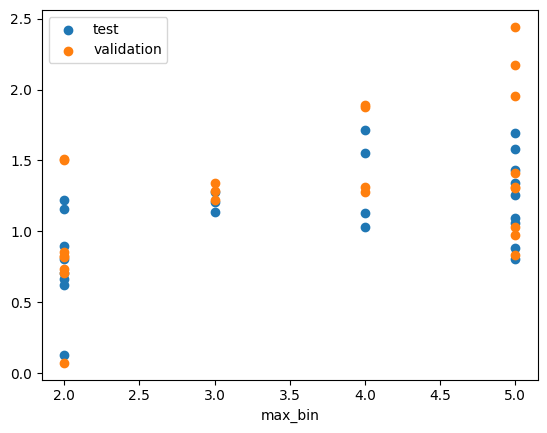

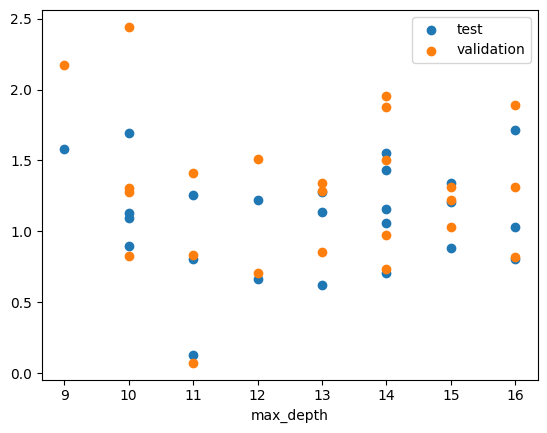

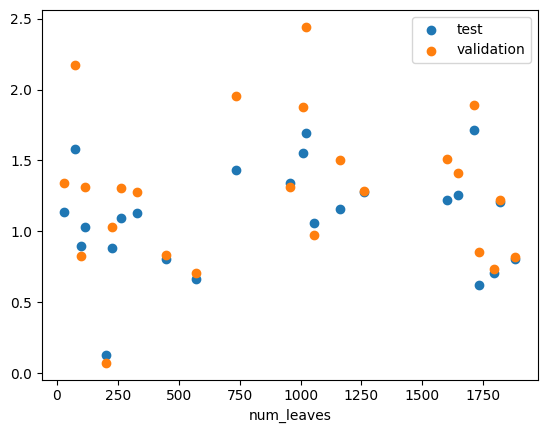

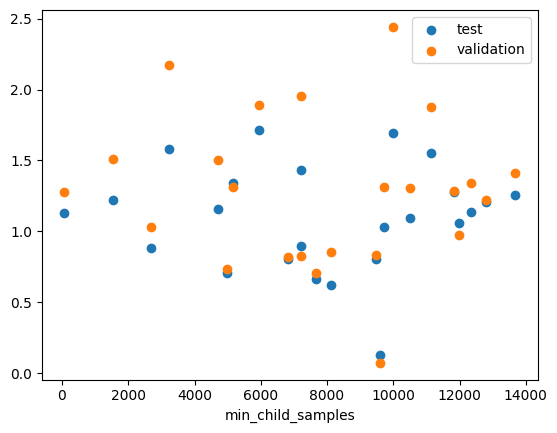

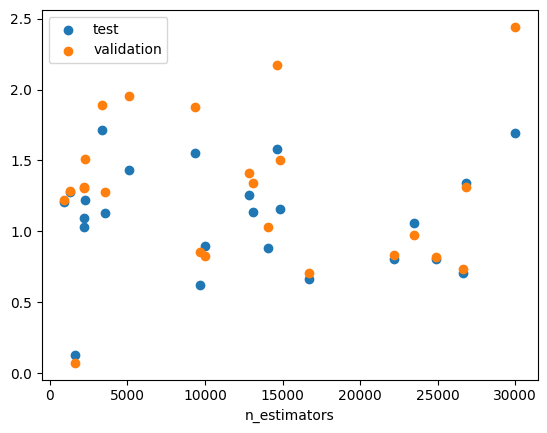

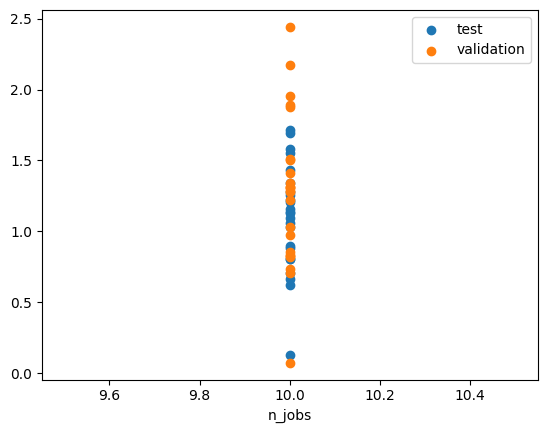

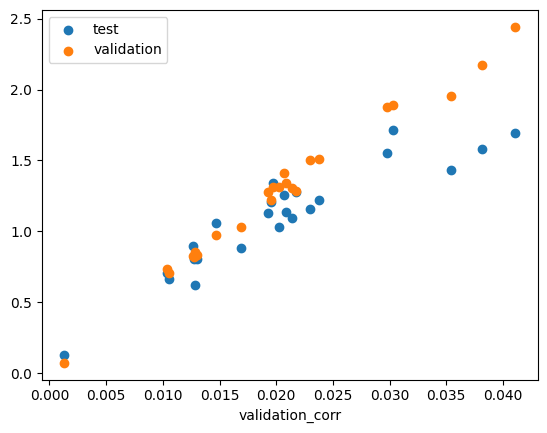

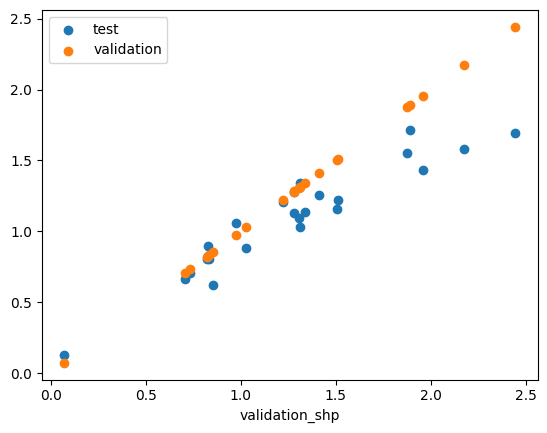

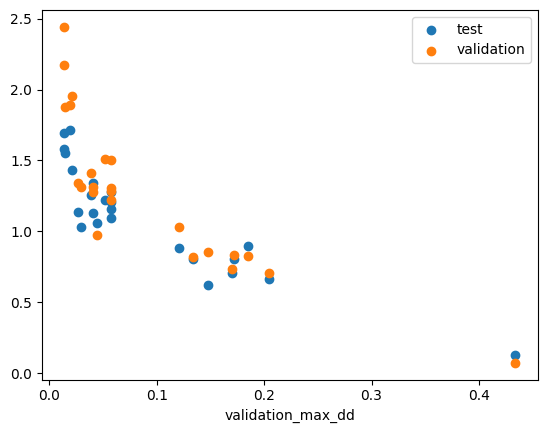

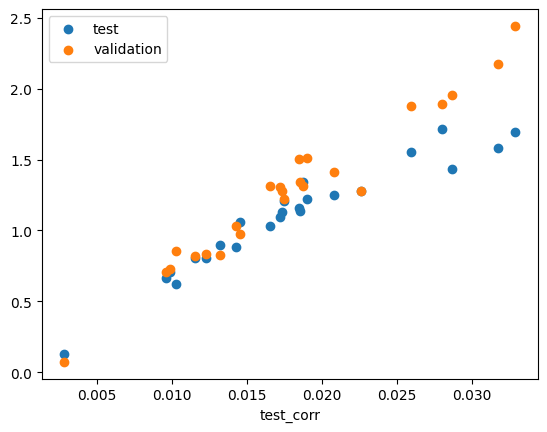

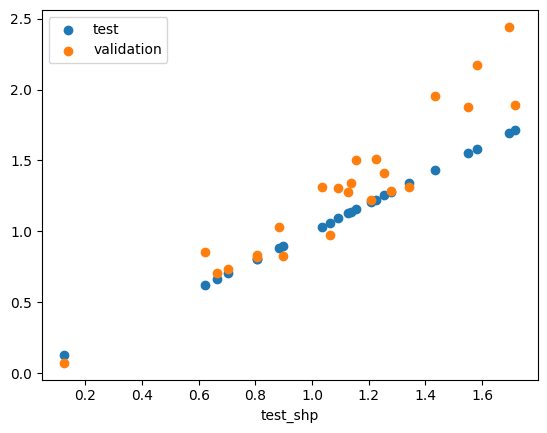

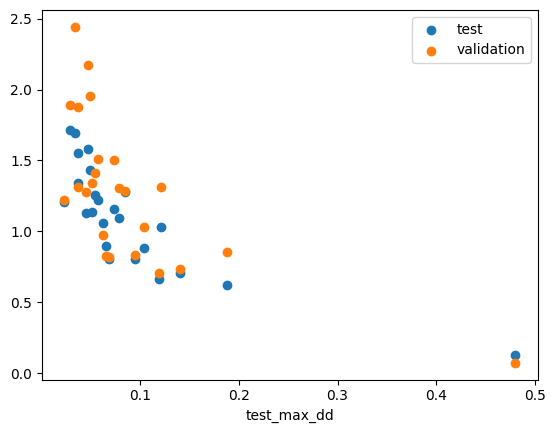

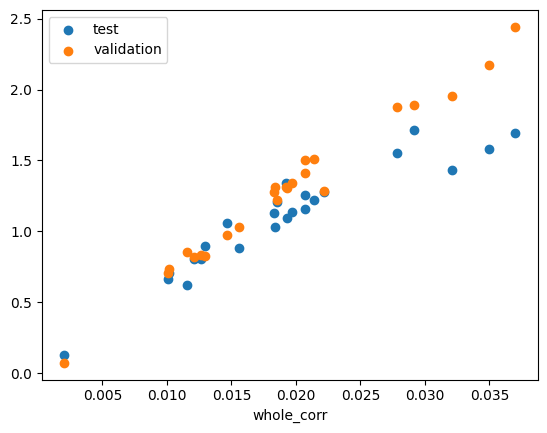

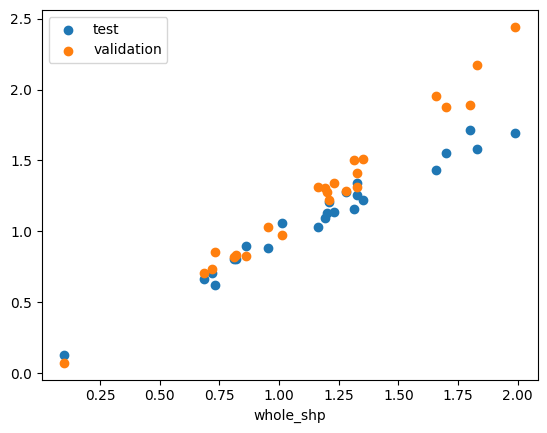

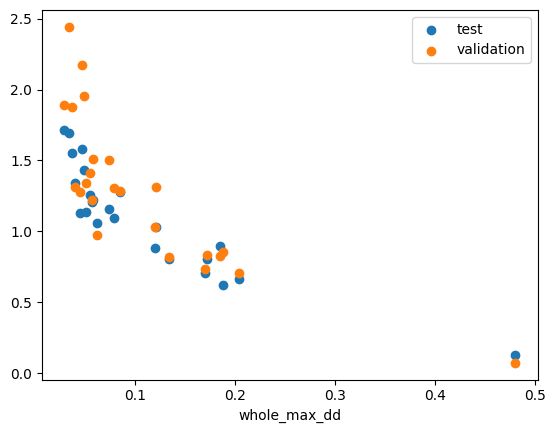

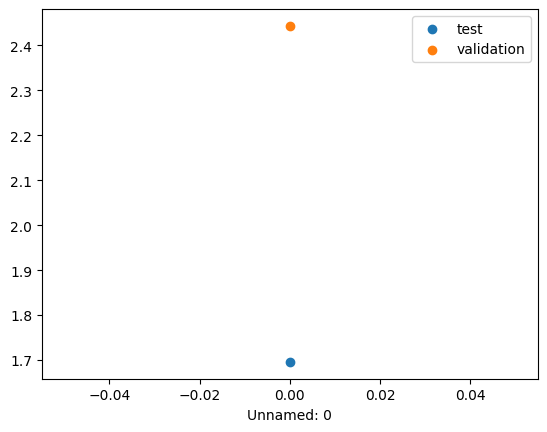

In [137]:
'''
Visualize performance as a function of hyper params
'''

import matplotlib.pyplot as plt

''''show some eval metrics based on each hyperparam, also only see this if we want, should be packages in its own method'''
for col in res_df.select_dtypes(include= np.number).columns:
    plt.scatter(res_df[col], res_df['test_shp'], label='test')
    plt.scatter(res_df[col], res_df['validation_shp'], label='validation')
    plt.xlabel(col)
    plt.legend()
    plt.show()

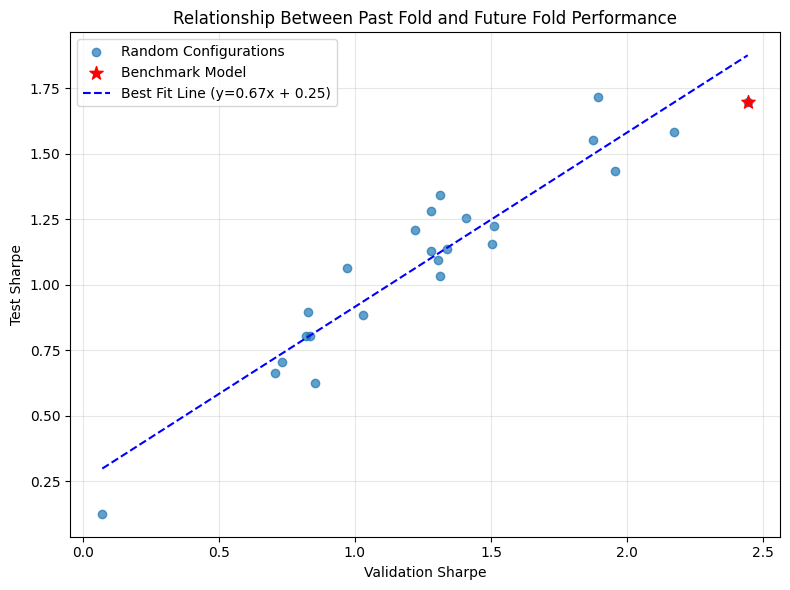

In [138]:
'''
IMPORTANT
Understand This Plot
Shows the relationship of past fold to future fold performance
'''
# Identify the benchmark configuration
benchmark_idx = BENCHMARK_ID
benchmark_validation_shp = res_df.loc[benchmark_idx, 'validation_shp']
benchmark_eval_shp = res_df.loc[benchmark_idx, 'test_shp']

# Scatter plot with enhancements
plt.figure(figsize=(8, 6))
plt.scatter(res_df['validation_shp'], res_df['test_shp'], alpha=0.7, label="Random Configurations")

# Highlight the benchmark model as a red star
plt.scatter(benchmark_validation_shp, benchmark_eval_shp, color='red', s=100, marker='*', label="Benchmark Model")

# Add a linear best-fit line
x = res_df['validation_shp']
y = res_df['test_shp']
m, b = np.polyfit(x, y, 1)  # Fit line: y = mx + b
plt.plot(x, m*x + b, color='blue', linestyle='--', label=f"Best Fit Line (y={m:.2f}x + {b:.2f})")

# Add labels, title, and legend
plt.xlabel("Validation Sharpe")
plt.ylabel("Test Sharpe")
plt.title("Relationship Between Past Fold and Future Fold Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('performance_scatter.png')

# Show the plot
plt.show()


In [131]:
print( done_splits[:100] )

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [117]:
res_df[['validation_shp','test_shp']].corr()

,validation_shp,test_shp
validation_shp,1.000000,0.845277
test_shp,0.845277,1.000000


In [98]:
to_export = [ res_df.sort_values('whole_shp').iloc[-1].name ] #can be a list to ensemble
to_export

[273]

In [99]:
evaluate_and_ensemble(to_export, configurations, mmapped_array, data, all_splits, feature_cols, get_model, save_name="model_273")

Selected ensemble: [273]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 35.045994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11880
[LightGBM] [Info] Number of data points in the train set: 3799413, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 61.483301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11880
[LightGBM] [Info] Number of data points in the train set: 6280796, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000030
Predict function saved as predict_model_273_full.pkl


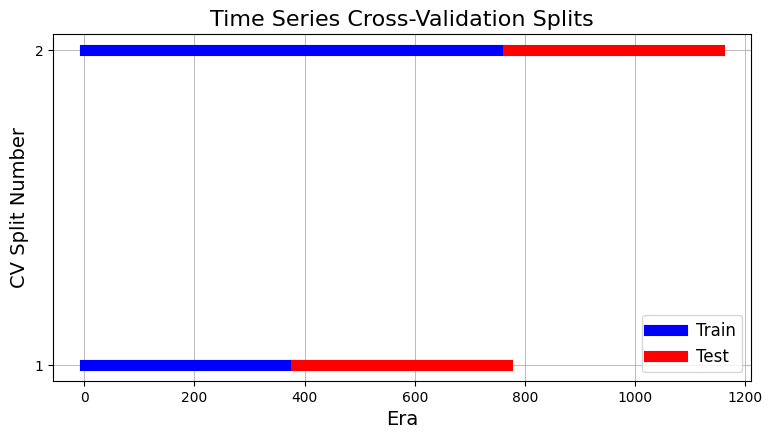

In [93]:

fig, ax = plt.subplots(figsize=(9, 4.5))  # Maintain the reduced size

for i, (train_idx, test_idx) in enumerate(all_splits):
    ax.plot(eras[train_idx], [i + 1] * len(train_idx), 'b-', linewidth=8, label='Train' if i == 0 else "")
    ax.plot(eras[test_idx], [i + 1] * len(test_idx), 'r-', linewidth=8, label='Test' if i == 0 else "")

# Formatting
ax.set_xlabel("Era", fontsize=14)
ax.set_ylabel("CV Split Number", fontsize=14)
ax.set_title("Time Series Cross-Validation Splits", fontsize=16)
ax.set_yticks(range(1, ns + 1))  # Show only whole integer ticks on y-axis
ax.legend(fontsize=12)
ax.grid(True, linewidth=0.6)

plt.show()